# Keplerian Motion vs. N-body

Pure two-body (Keplerian) propagation is orders of magnitude faster than a full N-body integration, and it can be a good approximation over short timescales. But how short is "short"? The answer depends on where an object lives in the solar system.

In this tutorial, we compare Keplerian and N-body ephemerides for representative objects from four populations:

| Population | Example object | Semi-major axis |
|---|---|---|
| Near-Earth Object | (433) Eros | ~1.5 AU |
| Main Belt | (6) Hebe | ~2.4 AU |
| Jupiter Trojan | (624) Hektor | ~5.2 AU |
| Trans-Neptunian Object | (15760) Albion | ~43 AU |

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

from jorbit import Particle

## Setup

We create two `Particle` objects for each body: one using `gravity="keplerian"` (pure two-body) and one using the full `gravity="default solar system"` model (PPN planets + 16 massive asteroids). We then compare their on-sky positions over 5 years.

In [13]:
epoch = Time("2025-01-01")
days = jnp.arange(1, 365 * 5, 5)  # every 5 days for 5 years
times = Time(days + epoch.tdb.jd, format="jd", scale="tdb")

objects = {
    "(1864) Daedalus\n(NEO, a$\\approx$1.5 AU)": "1864",
    "(274301) Wikipedia\n(Main Belt, a$\\approx$2.4 AU)": "274301",
    "(624) Hektor\n(Trojan, a$\\approx$5.2 AU)": "624",
    "(15760) Albion\n(TNO, a$\\approx$43 AU)": "15760",
}

In [14]:
separations = {}
for label, name in objects.items():
    p_kep = Particle.from_horizons(name=name, time=epoch, gravity="keplerian")
    p_nb = Particle.from_horizons(name=name, time=epoch, gravity="default solar system")

    eph_kep = p_kep.ephemeris(times, observer="kitt peak")
    eph_nb = p_nb.ephemeris(times, observer="kitt peak")

    observable_mask_kep = p_kep.is_observable(
        times, observer="kitt peak", sun_limit=20.0, ephem=eph_kep
    )
    observable_mask_nb = p_nb.is_observable(
        times, observer="kitt peak", sun_limit=20.0, ephem=eph_nb
    )
    observable_mask = observable_mask_kep & observable_mask_nb

    seps = eph_kep.separation(eph_nb).to(u.arcsec).value
    seps[~observable_mask] = np.nan

    separations[label] = seps
    print(f"{label.split(chr(10))[0]} done")

(1864) Daedalus done
(274301) Wikipedia done
(624) Hektor done
(15760) Albion done


## Comparison

Let's plot the on-sky separation between the Keplerian and N-body ephemerides for each object. The dashed lines mark 1 arcsecond and 1 arcminute for reference. Note that times when the objects were within 20 degrees of the Sun are masked out by our observability mask.

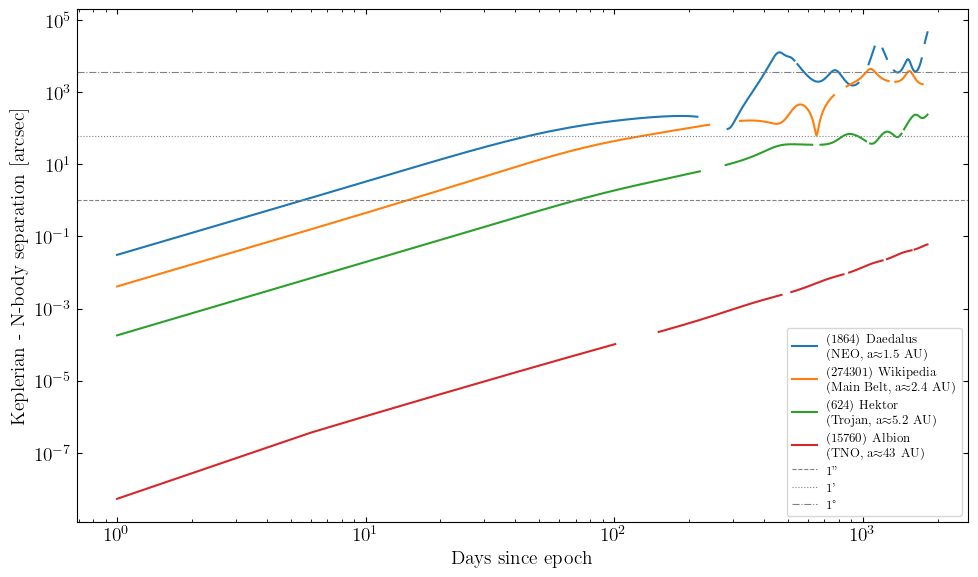

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

for label, sep in separations.items():
    ax.plot(days, sep, label=label)

ax.axhline(1, color="gray", ls="--", lw=0.8, label='1"')
ax.axhline(60, color="gray", ls=":", lw=0.8, label="1'")
ax.axhline(60 * 60, color="gray", ls="-.", lw=0.8, label="1°")

ax.set(
    xlabel="Days since epoch",
    ylabel="Keplerian - N-body separation [arcsec]",
    yscale="log",
    xscale="log",
)
ax.legend(fontsize=9)
fig.tight_layout()

## Discussion

A few takeaways:

- **NEOs** experience strong planetary perturbations and can diverge from Keplerian motion by arcseconds within days.
- **Main-belt asteroids** are constantly perturbed by Jupiter. The Keplerian approximation breaks down at the arcsecond level within a few weeks.
- **Jupiter Trojans** are slightly safer, but still show >1 arcsecond divergence within a few months.
- **TNOs** are the most weakly perturbed — their large heliocentric distances mean planetary perturbations are small. Keplerian motion can remain accurate to sub-arcsecond levels for several years.

For quick-look ephemerides or initial orbit determination, Keplerian propagation (via `gravity="keplerian"`) is fast and convenient. For precision work — orbit fitting, observation planning, or astrometric comparison — the full N-body model should be used.

## Batched Keplerian with `System`

When you need Keplerian ephemerides for many objects at once, the `System` class can evaluate them in a single vectorized call. This is fully vmapped (no sequential loops over particles or times), making it efficient for large batches.

In [16]:
from jorbit.system import System

particles = [
    Particle.from_horizons(name=name, time=epoch, gravity="keplerian")
    for name in objects.values()
]
sys = System(particles=particles, gravity="keplerian")

eph = sys.ephemeris(times, observer="kitt peak")
print(f"Ephemeris shape: {eph.ra.shape}  (N_particles, N_times)")

Ephemeris shape: (4, 365)  (N_particles, N_times)


In [17]:
# positions and velocities are also available
positions, velocities = sys.integrate(times)
print(f"Positions shape: {positions.shape}  (N_times, N_particles, 3)")

Positions shape: (365, 4, 3)  (N_times, N_particles, 3)
